In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('mode.chained_assignment', None)

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

## Exemplo simples: 6 pessoas (idade, renda)

In [2]:
dados = pd.DataFrame({'renda': [9.60, 8.40, 2.40, 18.20, 3.90, 6.40],
                     'idade': [28, 31, 42, 38, 25, 41]})
dados

,renda,idade
0,9.6,28
1,8.4,31
2,2.4,42
3,18.2,38
4,3.9,25
5,6.4,41


#### ACP usando a matriz de correlações

In [3]:
X = dados

In [4]:
pca = PCA() 
resultado_pca = pca.fit_transform(scale(X))   # scale(X) padroniza os dados, como se usássemos a matriz R

In [5]:
resultado = pd.DataFrame({'cp1': resultado_pca[:, 0], 'cp2': resultado_pca[:, 1]})

In [6]:
# coeficientes dos CPs (autovetores)
# cada linha é um CP
pca.components_

array([[ 0.70710678,  0.70710678],
       [-0.70710678,  0.70710678]])

Interpretação:

- Y1: quanto maior o escore positivo, maior idade e maior renda
- Y2: comparação entre idade e renda

In [7]:
# variâncias dos CPs (autovalores)
pca.explained_variance_

array([ 1.26442009,  1.13557991])

De acordo com o critério de apenas escolher autovalores maiores do que 1, os dois primeiros CPs seriam considerados.

In [8]:
# variância explicada acumulada
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([  52.68,  100.  ])

Pelo critério de explicação de cerca de 70%, seriam necessários os dois CPs.

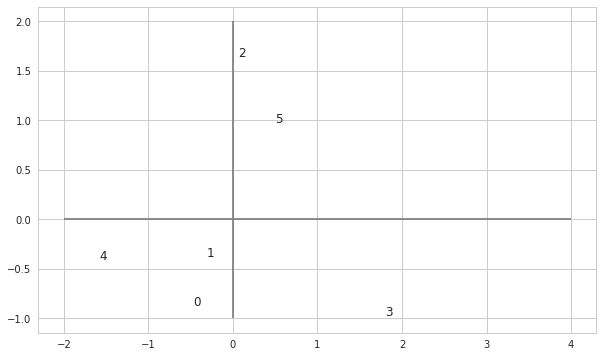

In [9]:
# diagrama de dispersão dos escores dos dois primeiros CPs
# rótulos: os índices dos indivíduos
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.scatter(resultado.cp1, resultado.cp2, s=0)
for i, txt in enumerate(resultado.index):
    ax.annotate(txt, (resultado.cp1[i], resultado.cp2[i]))
plt.hlines(0, -2, 4, color='gray')
plt.vlines(0, -1, 2, color='gray');

## Selecionar componentes principais

In [10]:
tot = sum(pca.explained_variance_)
var_exp = [(i / tot)*100 for i in sorted(pca.explained_variance_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([  52.68417037,  100.        ])

In [11]:
# número de CPs gerados (k = p)
cp =['CP'+str(i+1) for i in range(len(pca.components_))]
cp

['CP1', 'CP2']

In [12]:
df = pd.DataFrame({'cp': cp, 'var_exp': var_exp, 'cum_var_exp': cum_var_exp})
df

,cp,var_exp,cum_var_exp
0,CP1,52.68417,52.68417
1,CP2,47.31583,100.00000


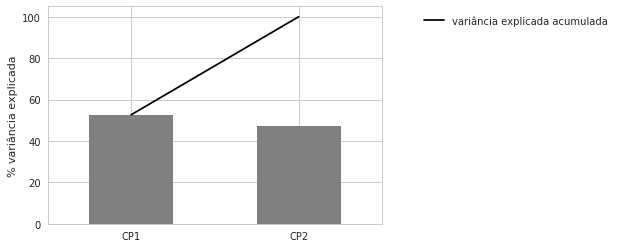

In [13]:
# scree plot
fig, ax = plt.subplots()
df.plot.bar('cp', 'var_exp', color='gray', ax=ax, legend=False)
df.plot.line('cp', 'cum_var_exp', color='black', ax=ax)
plt.legend(labels=['variância explicada acumulada'],
           loc='upper right', 
           bbox_to_anchor=(1.7, 1))
plt.ylabel('% variância explicada')
plt.xlabel('');

### Análise de agrupamento

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [15]:
X = dados

In [16]:
# usar os 5 métodos vistos (single, complete, average, centroid, ward)
# e avaliar os agrupamentos obtidos
Z = linkage(X, method='ward')
# method='single' (vizinho + próximo)
# 'complete' (vizinho + distante)
# 'average' (distância média)
# 'weighted '(also called WPGMA)
# 'centroid' 
# 'median'
# 'ward'

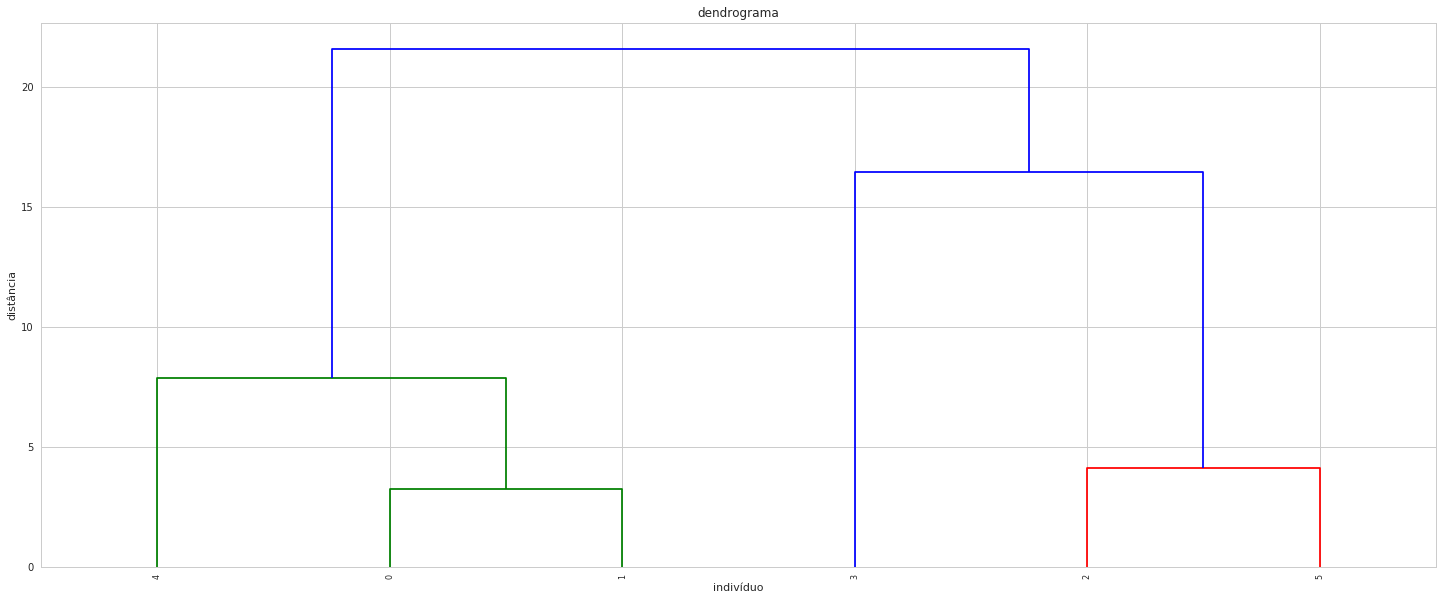

In [17]:
# obter o dendrograma de forma mais automática - função dendrogram
plt.figure(figsize=(25, 10))
plt.title('dendrograma')
plt.xlabel('indivíduo')
plt.ylabel('distância')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotação do eixo
    leaf_font_size=8.,  # tamanho da fonte
)
plt.show()

In [18]:
# definir a distância de corte baseando no dendrograma
max_d = 10

In [19]:
# função para gerar dendrograma com algumas outras informações
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

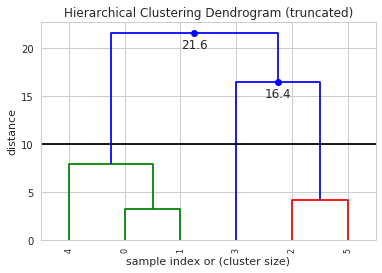

In [20]:
d = fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,    # últimos agrupamentos realizados
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # linha de corte
);

**Atenção**: avaliar o dendrograma e escolher o n_clusters apropriado

In [21]:
# lista com os grupos referentes às observações
# escolher quantos grupos serão obtidos
from scipy.cluster.hierarchy import cut_tree
grupos = cut_tree(Z, n_clusters=[3])
grupos

array([[0],
       [0],
       [1],
       [2],
       [0],
       [1]])

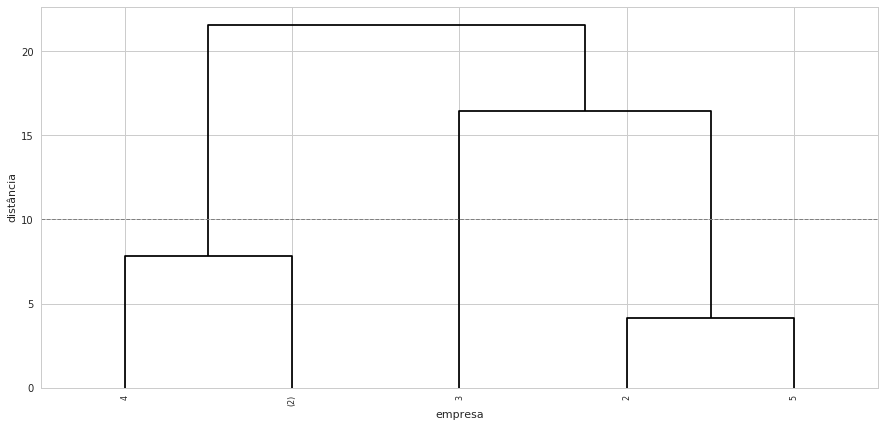

In [22]:
# dendrograma com mais opções
# mostra o ponto de corte na distância max_d
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('empresa')
plt.ylabel('distância');

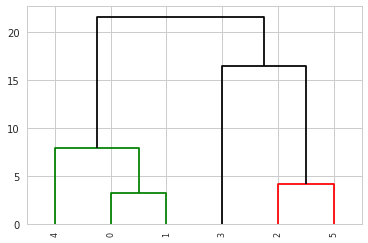

In [23]:
a = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=8,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=max_d, # para que os grupos fiquem com cores diferentes
);

In [24]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos
resultado['grupo'] = grupos
resultado.shape

(6, 3)

In [25]:
resultado

,cp1,cp2,grupo
0,-0.468876,-0.869299,0
1,-0.309066,-0.378105,0
2,0.055981,1.643863,1
3,1.803590,-0.971751,2
4,-1.581416,-0.407764,0
5,0.499787,0.983056,1


In [26]:
# contagem de observações em cada grupo
resultado.grupo.value_counts()

0    3
1    2
2    1
Name: grupo, dtype: int64

In [27]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
dados['grupo'] = grupos
dados.head()

,renda,idade,grupo
0,9.6,28,0
1,8.4,31,0
2,2.4,42,1
3,18.2,38,2
4,3.9,25,0


In [28]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados.groupby('grupo').mean()

,renda,idade
grupo,,
0,7.3,28.0
1,4.4,41.5
2,18.2,38.0


In [29]:
# mediana das variáveis para cada grupo
dados.groupby('grupo').median()

,renda,idade
grupo,,
0,8.4,28.0
1,4.4,41.5
2,18.2,38.0


In [30]:
# desvio padrão
dados.groupby('grupo').std()

,renda,idade
grupo,,
0,3.004996,3.000000
1,2.828427,0.707107
2,NaN,NaN


## As observações de cada grupo

In [31]:
grupo0 = dados.query('grupo == 0').index
pd.DataFrame(list(grupo0))

,0
0,0
1,1
2,4


In [32]:
grupo1 = dados.query('grupo == 1').index
pd.DataFrame(list(grupo1))

,0
0,2
1,5


In [33]:
grupo2 = dados.query('grupo == 2').index
pd.DataFrame(list(grupo2))

,0
0,3


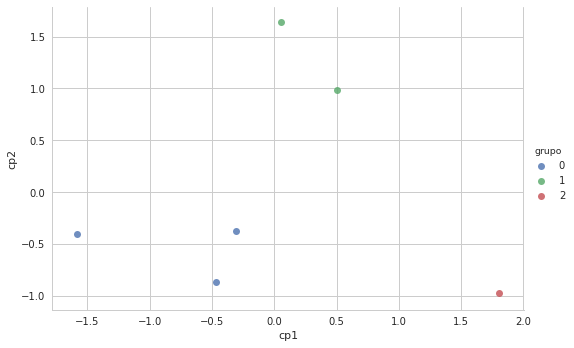

In [34]:
# plotar os escores dos CPs dos 3 grupos
sns.lmplot('cp1', 'cp2', hue='grupo', fit_reg=False, data=resultado, aspect=1.5);

In [35]:
resultado['indivíduo'] = resultado.index

In [36]:
# pacote altair para fazer outros tipos de gráficos
# usaremos para o diagrama de dispersão com a cor de acordo com a mesorregião
import altair as alt
alt.renderers.enable('notebook');
# pacote para ter mais opções de paletas de cores
import palettable
# https://vega.github.io/vega/docs/schemes/#reference

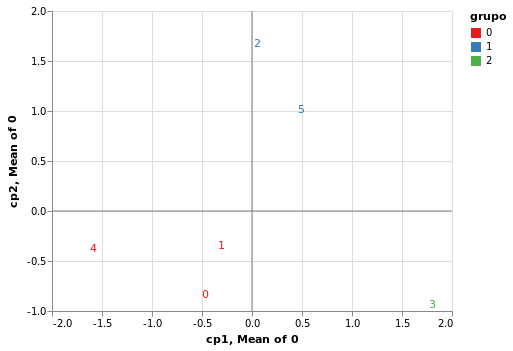

In [37]:
# gráficos
g = alt.Chart(resultado).mark_text().encode(
    alt.X('cp1', scale=alt.Scale(domain=[-2, 2])),
    alt.Y('cp2', scale=alt.Scale(domain=[-1, 2])),
    text='indivíduo',
    color=alt.Color('grupo:O', scale=alt.Scale(scheme='set1'))
)
# eixo x = 0
bar_x = alt.Chart(resultado).mark_rule(color='gray').encode(
    x='mean(0):Q')

# eixo y = 0
bar_y = alt.Chart(resultado).mark_rule(color='gray').encode(
    y='mean(0):Q')


g + bar_x + bar_y

## Exemplo dos dados das empresas

Dados de doze empresas e 3 variáveis - exemplo de MINGOTI (2005). Vamos criar o *dataframe* usando a função *DataFrame* do *pandas*. Poderíamos também ter os dados salvos em uma planilha e usar a função *read_csv* para lê-la.

In [38]:
# ganho bruto - B (X1)
# ganho líquido - L (X2)
# patrimônio acumulado - P (X3)
dados = pd.DataFrame({'B': [9893,8776,13572,6455,5129,5432,3807,3423,3708,3294,5433,6287],
                  'L': [564,389,1103,743,203,215,385,187,127,297,432,451],
                  'P': [17689,17359,18597,8745,14397,3467,4679,6754,2275,6754,5589,8972]})
dados

,B,L,P
0,9893,564,17689
1,8776,389,17359
2,13572,1103,18597
3,6455,743,8745
4,5129,203,14397
5,5432,215,3467
6,3807,385,4679
7,3423,187,6754
8,3708,127,2275
9,3294,297,6754


#### ACP usando a matriz de correlações

In [42]:
X = dados

In [43]:
pca = PCA() 
resultado_pca = pca.fit_transform(scale(X))   # scale(X) padroniza os dados, como se usássemos a matriz R

In [44]:
resultado = pd.DataFrame({'cp1': resultado_pca[:, 0], 'cp2': resultado_pca[:, 1]})

In [45]:
# coeficientes dos CPs (autovetores)
# cada linha é um CP
pca.components_

array([[ 0.61670267,  0.55679445,  0.556469  ],
       [-0.00126721, -0.70619694,  0.70801432],
       [ 0.78719515, -0.43733949, -0.43480796]])

Interpretação:

- Y1: índice de desempenho global da empresa (valores altos positivos indicam empresas que tiveram ganhos B, L e P maiores do que a média)
- Y2: comparação entre L e P (valores ~ 0 indicam empresas em que L está em equilíbrio com P)
- Y3: comparação de B com o índice composto por por L e P (representa pouco da variação total, mas pode ser de interesse para o pesquisador)

In [46]:
# variâncias dos CPs (autovalores)
pca.explained_variance_

array([ 2.71912594,  0.46199796,  0.09160337])

De acordo com o critério de apenas escolher autovalores maiores do que 1, apenas o primeiro CP seria considerado.

In [47]:
# variância explicada acumulada
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([  83.08,   97.2 ,  100.  ])

Pelo critério de explicação de cerca de 70%, apenas o primeiro CP seria considerado.

In [48]:
# escores dos dois primeiros CPs
resultado

,cp1,cp2
0,1.849933,0.645271
1,1.215910,1.071540
2,3.841723,-0.681407
3,0.624086,-0.958889
4,-0.229387,1.196460
5,-1.223956,-0.213646
6,-1.084577,-0.514195
7,-1.375958,0.276384
8,-1.886702,-0.128149
9,-1.171209,-0.017351


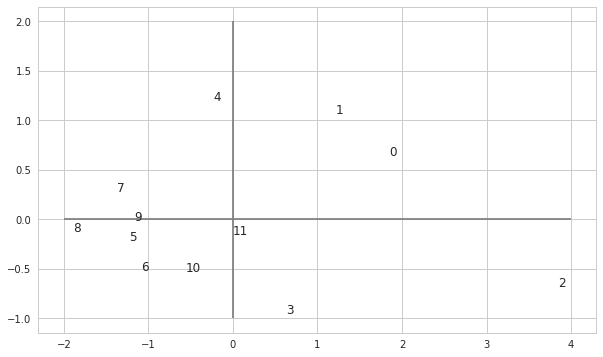

In [49]:
# diagrama de dispersão dos escores dos dois primeiros CPs
# rótulos: os índices das empresas
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.scatter(resultado.cp1, resultado.cp2, s=0)
for i, txt in enumerate(resultado.index):
    ax.annotate(txt, (resultado.cp1[i], resultado.cp2[i]))
plt.hlines(0, -2, 4, color='gray')
plt.vlines(0, -1, 2, color='gray');

## Selecionar componentes principais

In [50]:
tot = sum(pca.explained_variance_)
var_exp = [(i / tot)*100 for i in sorted(pca.explained_variance_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([  83.08440382,   97.20100811,  100.        ])

In [51]:
# número de CPs gerados (k = p)
cp =['CP'+str(i+1) for i in range(len(pca.components_))]
cp

['CP1', 'CP2', 'CP3']

In [52]:
df = pd.DataFrame({'cp': cp, 'var_exp': var_exp, 'cum_var_exp': cum_var_exp})
df

,cp,var_exp,cum_var_exp
0,CP1,83.084404,83.084404
1,CP2,14.116604,97.201008
2,CP3,2.798992,100.000000


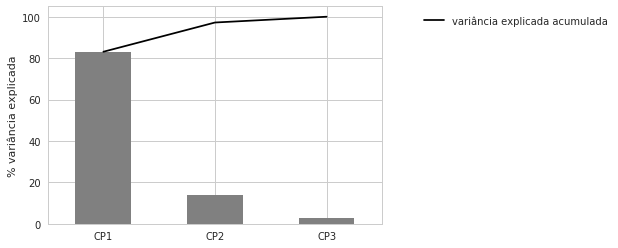

In [53]:
# scree plot
fig, ax = plt.subplots()
df.plot.bar('cp', 'var_exp', color='gray', ax=ax, legend=False)
df.plot.line('cp', 'cum_var_exp', color='black', ax=ax)
plt.legend(labels=['variância explicada acumulada'],
           loc='upper right', 
           bbox_to_anchor=(1.7, 1))
plt.ylabel('% variância explicada')
plt.xlabel('');

Os dois primeiros CPs explicam 97% da variação total. Ficaremos com os dois primeiros para poder fazer o diagrama de dispersão. Mas poderíamos ficar apenas com o primeiro.

### Análise de agrupamento

In [54]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [55]:
X = dados

In [56]:
Z = linkage(X, method='ward')
# method='single' (vizinho + próximo)
# 'complete' (vizinho + distante)
# 'average' (distância média)
# 'weighted '(also called WPGMA)
# 'centroid' 
# 'median'
# 'ward'

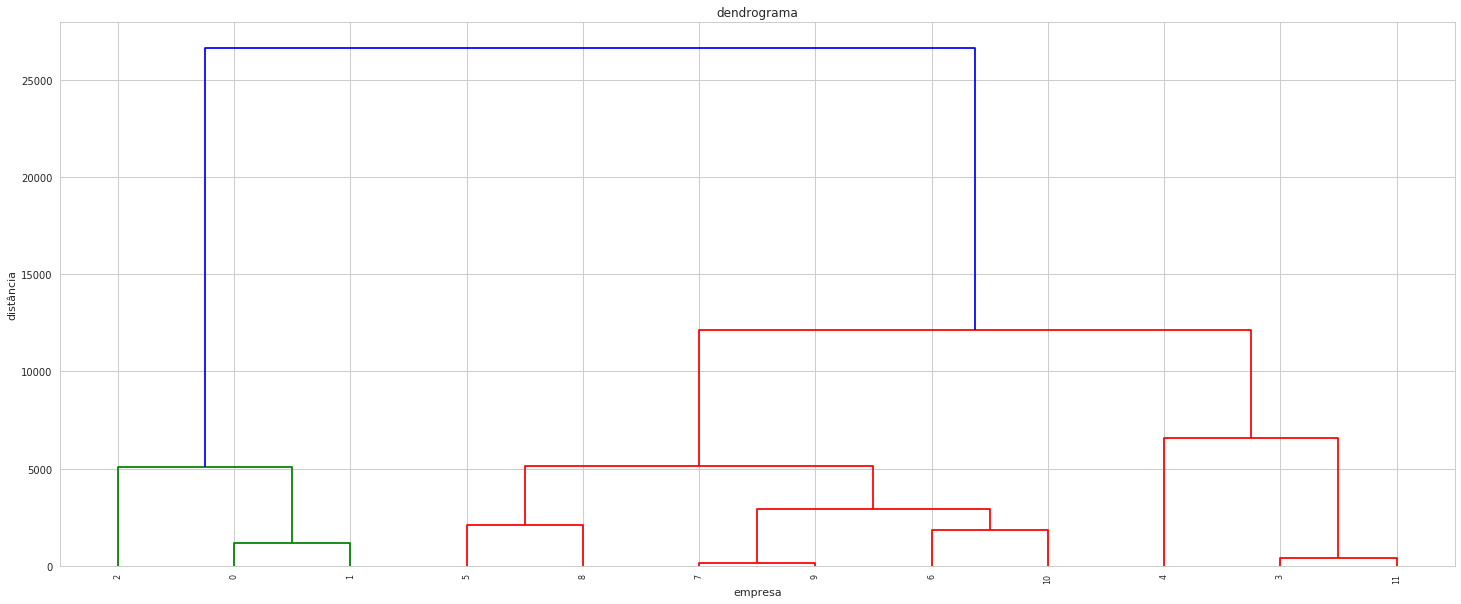

In [57]:
# obter o dendrograma de forma mais automática - função dendrogram
plt.figure(figsize=(25, 10))
plt.title('dendrograma')
plt.xlabel('empresa')
plt.ylabel('distância')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotação do eixo
    leaf_font_size=8.,  # tamanho da fonte
)
plt.show()

O dendrograma truncado mostra os últimos agrupamentos realizados:

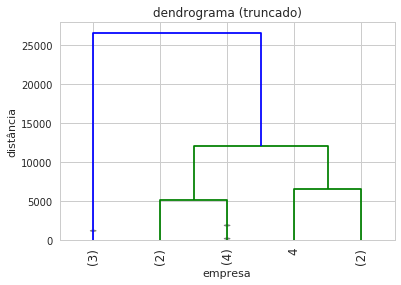

In [58]:
# dendrograma truncado - mostra últimos agrupamentos
plt.title('dendrograma (truncado)')
plt.xlabel('empresa')
plt.ylabel('distância')
dendrogram(
    Z,
    truncate_mode='lastp',  # mostra apenas os p últimos agrupamentos realizados
    p=5,  # p últimos agrupamentos
    show_leaf_counts=True,  # números entre parênteses informam quantas observações há no grupo
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
);

In [59]:
# definir a distância de corte baseando no dendrograma
max_d = 10000

In [62]:
# lista com os grupos referentes às observações
from scipy.cluster.hierarchy import cut_tree
grupos = cut_tree(Z, n_clusters=[3])
grupos

array([[0],
       [0],
       [0],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1]])

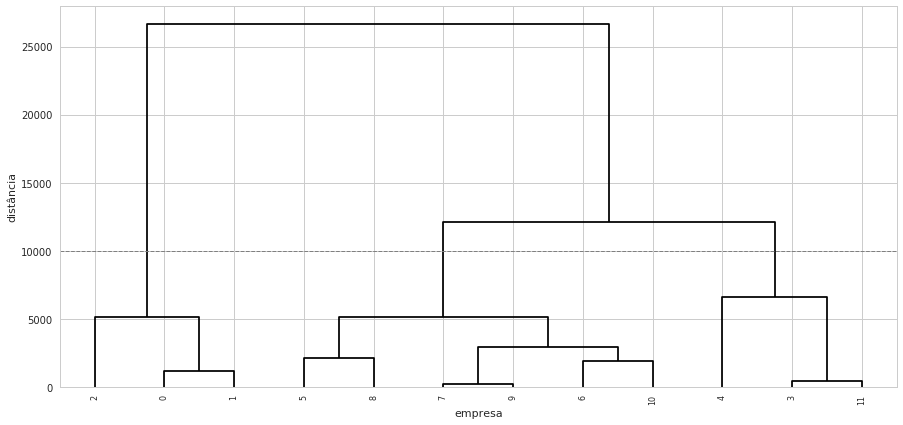

In [63]:
# mostra o ponto de corte na distância max_d
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=40,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('empresa')
plt.ylabel('distância');

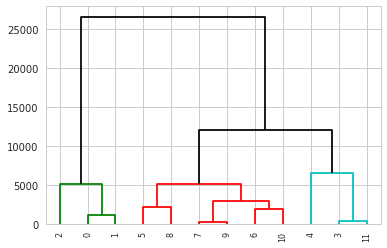

In [64]:
a = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=40,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=max_d, # para que os grupos fiquem com cores diferentes
);

In [65]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos
resultado['grupo'] = grupos

In [66]:
resultado.shape

(12, 3)

In [67]:
resultado

,cp1,cp2,grupo
0,1.849933,0.645271,0
1,1.215910,1.071540,0
2,3.841723,-0.681407,0
3,0.624086,-0.958889,1
4,-0.229387,1.196460,1
5,-1.223956,-0.213646,2
6,-1.084577,-0.514195,2
7,-1.375958,0.276384,2
8,-1.886702,-0.128149,2
9,-1.171209,-0.017351,2


In [68]:
# contagem de observações em cada grupo
resultado.grupo.value_counts()

2    6
1    3
0    3
Name: grupo, dtype: int64

In [69]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
dados['grupo'] = grupos
dados.head()

,B,L,P,grupo
0,9893,564,17689,0
1,8776,389,17359,0
2,13572,1103,18597,0
3,6455,743,8745,1
4,5129,203,14397,1


In [70]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados.groupby('grupo').mean()

,B,L,P
grupo,,,
0,10747.000000,685.333333,17881.666667
1,5957.000000,465.666667,10704.666667
2,4182.833333,273.833333,4919.666667


In [71]:
# mediana das variáveis para cada grupo
dados.groupby('grupo').median()

,B,L,P
grupo,,,
0,9893.0,564.0,17689.0
1,6287.0,451.0,8972.0
2,3757.5,256.0,5134.0


In [72]:
# desvio padrão
dados.groupby('grupo').std()

,B,L,P
grupo,,,
0,2509.460301,372.142894,641.093857
1,721.972299,270.298600,3199.668160
2,985.639167,118.720540,1807.760345


## As observações de cada grupo

In [73]:
grupo0 = dados.query('grupo == 0').index
pd.DataFrame(list(grupo0))

,0
0,0
1,1
2,2


In [74]:
grupo1 = dados.query('grupo == 1').index
pd.DataFrame(list(grupo1))

,0
0,3
1,4
2,11


In [75]:
grupo2 = dados.query('grupo == 2').index
pd.DataFrame(list(grupo2))

,0
0,5
1,6
2,7
3,8
4,9
5,10


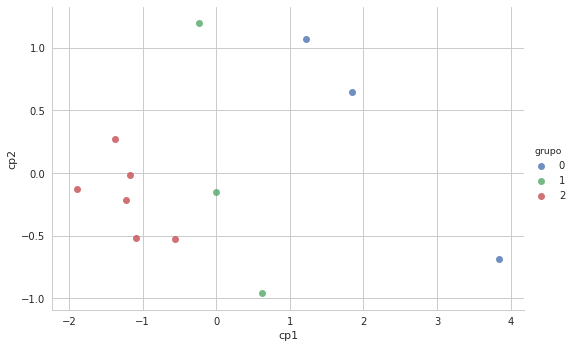

In [76]:
# plotar os escores dos CPs dos 3 grupos
sns.lmplot('cp1', 'cp2', hue='grupo', fit_reg=False, data=resultado, aspect=1.5);

In [77]:
resultado['empresa'] = resultado.index

In [78]:
# pacote altair para fazer outros tipos de gráficos
# usaremos para o diagrama de dispersão com a cor de acordo com a mesorregião
import altair as alt
alt.renderers.enable('notebook');
# pacote para ter mais opções de paletas de cores
import palettable
# https://vega.github.io/vega/docs/schemes/#reference

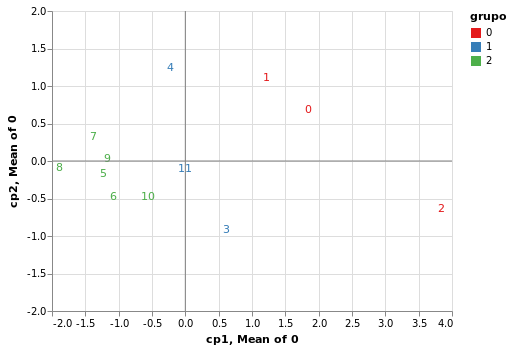

In [79]:
# gráficos
g = alt.Chart(resultado).mark_text().encode(
    alt.X('cp1', scale=alt.Scale(domain=[-2, 4])),
    alt.Y('cp2', scale=alt.Scale(domain=[-2, 2])),
    text='empresa',
    color=alt.Color('grupo:O', scale=alt.Scale(scheme='set1'))
)
# eixo x = 0
bar_x = alt.Chart(resultado).mark_rule(color='gray').encode(
    x='mean(0):Q')

# eixo y = 0
bar_y = alt.Chart(resultado).mark_rule(color='gray').encode(
    y='mean(0):Q')


g + bar_x + bar_y

### Exemplo de MG - imrs

In [2]:
dados = pd.read_excel('/home/patricia/drive/unifal/analise_multivariada/2018_1/trabalho/imrs-resumido-2016.xlsx', index_col='mun')

In [3]:
dados.head()

,ibge7,popul,rdpc_formal,tx_mort,prop_priv_saude
mun,,,,,
Abadia dos Dourados,3100104,7037,540.70,4.55,15.32
Abaeté,3100203,23574,258.94,6.32,14.01
Abre Campo,3100302,13726,152.43,7.07,4.26
Acaiaca,3100401,4061,132.16,5.17,6.06
Açucena,3100500,10066,59.31,7.45,9.40


In [4]:
# dados2: incluir código para usar depois
dados2 = dados
# resultado2 = resultado.reset_index()
cod = pd.read_csv('/home/patricia/drive/unifal/analise_multivariada/2018_1/trabalho/codigos-mun.csv')
cod = cod[['mun', 'nome_mun', 'nome_meso']]
cod.rename(columns={'mun': 'ibge7'}, inplace=True)
dados2 = dados2.merge(cod)

In [5]:
dados2.head()

,ibge7,popul,rdpc_formal,tx_mort,prop_priv_saude,nome_mun,nome_meso
0,3100104,7037,540.70,4.55,15.32,Abadia dos Dourados,Triângulo Mineiro/Alto Paranaíba
1,3100203,23574,258.94,6.32,14.01,Abaeté,Central Mineira
2,3100302,13726,152.43,7.07,4.26,Abre Campo,Zona da Mata
3,3100401,4061,132.16,5.17,6.06,Acaiaca,Zona da Mata
4,3100500,10066,59.31,7.45,9.40,Açucena,Vale do Rio Doce


In [6]:
# verificar se tem algum valor faltante
dados.isnull().any()

ibge7              False
popul              False
rdpc_formal        False
tx_mort            False
prop_priv_saude    False
dtype: bool

In [7]:
dados.iloc[:,1:6].describe()

,popul,rdpc_formal,tx_mort,prop_priv_saude
count,8.530000e+02,853.000000,853.000000,853.000000
mean,2.461613e+04,224.721923,6.817280,10.074572
std,1.000713e+05,229.002939,1.633406,10.319930
min,8.150000e+02,21.400000,1.450000,0.080000
25%,4.940000e+03,104.560000,5.750000,2.660000
50%,8.283000e+03,169.790000,6.750000,6.220000
75%,1.803600e+04,262.320000,7.740000,14.260000
max,2.513451e+06,3296.670000,16.520000,68.290000


In [8]:
# médias
dados.iloc[:,1:6].mean()

popul              24616.131301
rdpc_formal          224.721923
tx_mort                6.817280
prop_priv_saude       10.074572
dtype: float64

In [9]:
dados.iloc[:,1:6].cov()

,popul,rdpc_formal,tx_mort,prop_priv_saude
popul,1.001427e+10,7.185591e+06,-9804.940018,352040.644352
rdpc_formal,7.185591e+06,5.244235e+04,-20.524976,1367.664141
tx_mort,-9.804940e+03,-2.052498e+01,2.668014,-0.237378
prop_priv_saude,3.520406e+05,1.367664e+03,-0.237378,106.500946


In [10]:
dados.iloc[:,1:6].corr()

,popul,rdpc_formal,tx_mort,prop_priv_saude
popul,1.000000,0.313554,-0.059985,0.340884
rdpc_formal,0.313554,1.000000,-0.054872,0.578711
tx_mort,-0.059985,-0.054872,1.000000,-0.014082
prop_priv_saude,0.340884,0.578711,-0.014082,1.000000


In [11]:
dados.columns

Index(['ibge7', 'popul', 'rdpc_formal', 'tx_mort', 'prop_priv_saude'], dtype='object')

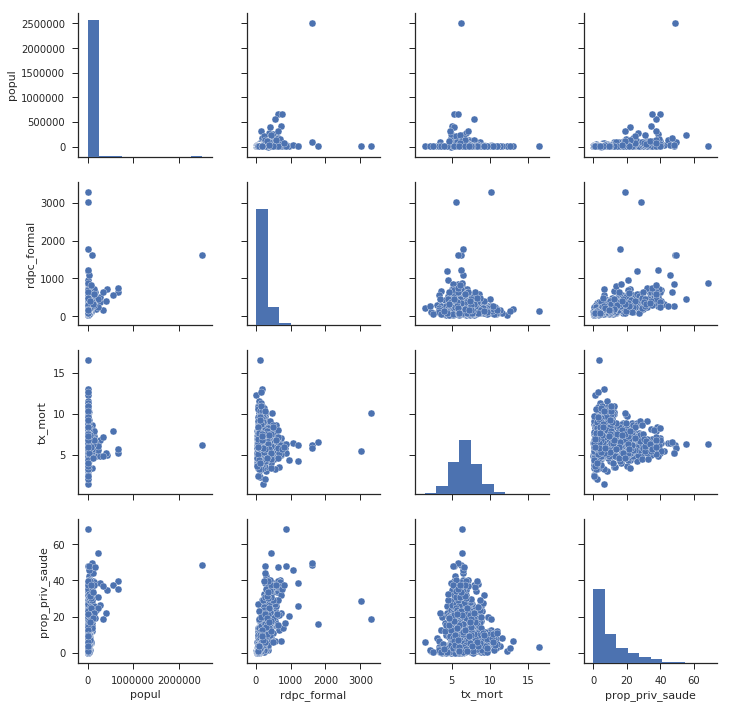

In [12]:
sns.set(style='ticks')
sns.pairplot(dados.iloc[:,1:11]);

### ACP

In [13]:
# subselecionar variáveis
X = dados.iloc[:,1:5]

In [14]:
pca = PCA() 
resultado_pca = pca.fit_transform(scale(X))   # scale(X) padroniza os dados, como se usássemos a matriz R

In [15]:
resultado = pd.DataFrame({'cp1': resultado_pca[:, 0], 'cp2': resultado_pca[:, 1]}, index=dados.index)

In [16]:
# coeficientes dos CPs (autovetores)
# cada linha é um CP
pca.components_

array([[ 0.48493896,  0.61202337, -0.08485521,  0.61891938],
       [-0.05430099,  0.05573001,  0.98934188,  0.12307807],
       [ 0.87118714, -0.38007152,  0.10558684, -0.29228417],
       [ 0.05402394,  0.69127939,  0.05341962, -0.71858232]])

Interpretação:

- $Y_1$: quanto maior o escore positivo, maiores: tamanho da população, rendimento do setor formal e % de planos de saúde.
- $Y_2$: mais influenciado pela taxa de mortalidade. Quanto maior o escore positivo, maior a taxa de mortalidade. 

In [17]:
# variâncias dos CPs (autovalores)
pca.explained_variance_

array([ 1.84344578,  0.9996214 ,  0.74243991,  0.41918775])

De acordo com o critério de apenas escolher autovalores maiores do que 1, os dois primeiros CPs seriam considerados.

In [18]:
# variância explicada acumulada
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([  46.03,   70.99,   89.53,  100.  ])

Pelo critério de explicação de cerca de 70% seriam também os dois primeiros.

In [19]:
# escores dos dois primeiros CPs
resultado.head()

,cp1,cp2
mun,,
Abadia dos Dourados,1.192351,-1.225000
Abaeté,0.348458,-0.245515
Abre Campo,-0.608181,0.072083
Acaiaca,-0.502471,-1.057617
Açucena,-0.586251,0.343030


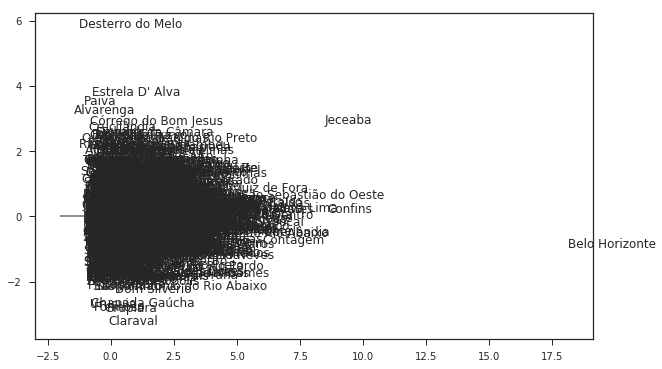

In [20]:
# diagrama de dispersão dos escores dos dois primeiros CPs
# rótulos: os índices das empresas
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.scatter(resultado.cp1, resultado.cp2, s=0)
for i, txt in enumerate(resultado.index):
    ax.annotate(txt, (resultado.cp1[i], resultado.cp2[i]))
plt.hlines(0, -2, 4, color='gray')
plt.vlines(0, -1, 2, color='gray');

## Selecionar componentes principais

In [21]:
tot = sum(pca.explained_variance_)
var_exp = [(i / tot)*100 for i in sorted(pca.explained_variance_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([ 46.03211628,  70.99335399,  89.53259196, 100.        ])

In [22]:
# número de CPs gerados (k = p)
cp =['CP'+str(i+1) for i in range(len(pca.components_))]
cp

['CP1', 'CP2', 'CP3', 'CP4']

In [23]:
df = pd.DataFrame({'cp': cp, 'var_exp': var_exp, 'cum_var_exp': cum_var_exp})
df

,cp,var_exp,cum_var_exp
0,CP1,46.032116,46.032116
1,CP2,24.961238,70.993354
2,CP3,18.539238,89.532592
3,CP4,10.467408,100.000000


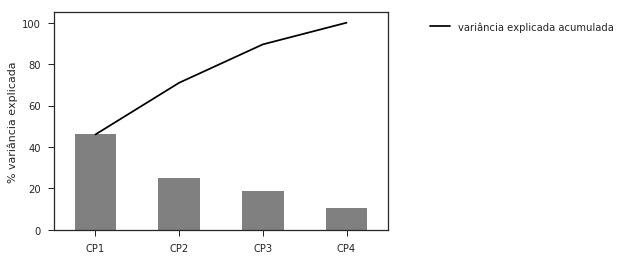

In [24]:
# scree plot
fig, ax = plt.subplots()
df.plot.bar('cp', 'var_exp', color='gray', ax=ax, legend=False)
df.plot.line('cp', 'cum_var_exp', color='black', ax=ax)
plt.legend(labels=['variância explicada acumulada'],
           loc='upper right', 
           bbox_to_anchor=(1.7, 1))
plt.ylabel('% variância explicada')
plt.xlabel('');

Os dois primeiros CPs explicam 71% da variação total. Ficaremos com os dois primeiros.

### Análise de agrupamento

In [25]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [26]:
Z = linkage(X, method='ward')
# method='single' (vizinho + próximo)
# 'complete' (vizinho + distante)
# 'average' (distância média)
# 'weighted '(also called WPGMA)
# 'centroid' 
# 'median'
# 'ward'

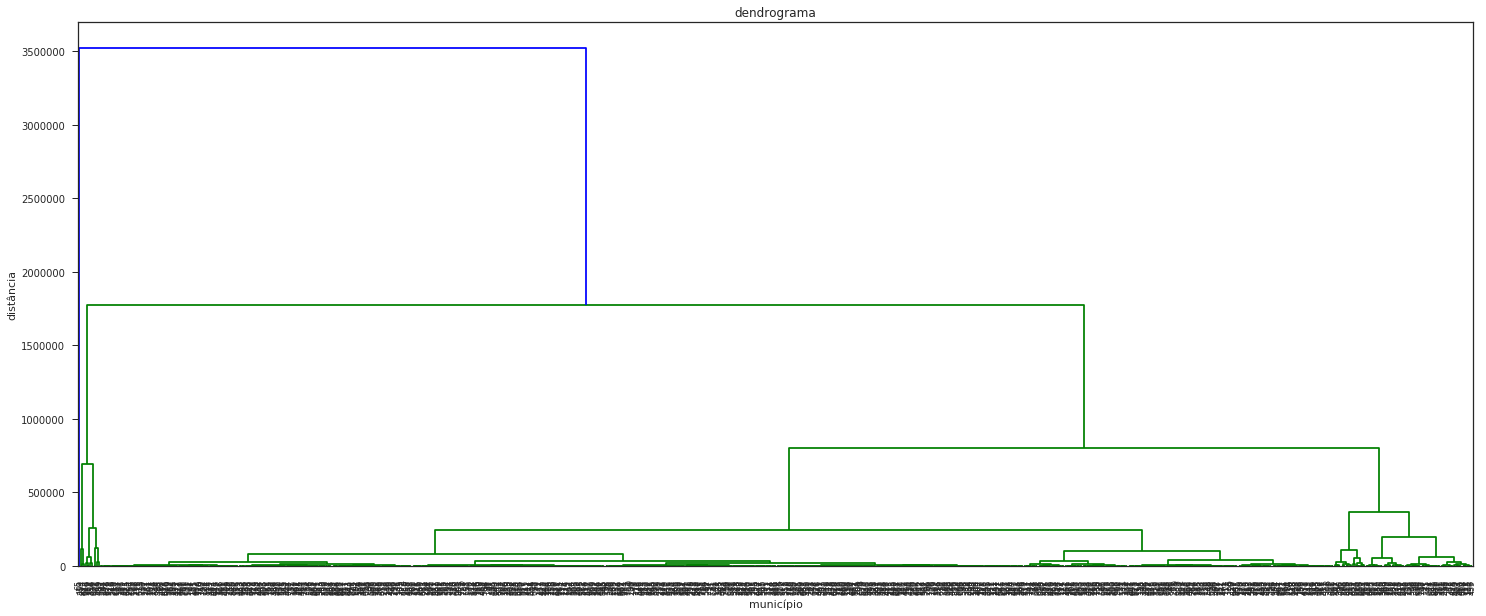

In [27]:
# obter o dendrograma de forma mais automática - função dendrogram
plt.figure(figsize=(25, 10))
plt.title('dendrograma')
plt.xlabel('município')
plt.ylabel('distância')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotação do eixo
    leaf_font_size=8.,  # tamanho da fonte
)
plt.show()

O dendrograma truncado mostra os últimos agrupamentos realizados:

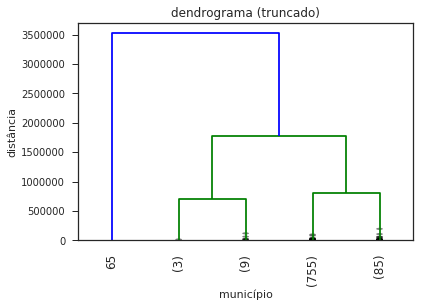

In [28]:
# dendrograma truncado - mostra últimos agrupamentos
plt.title('dendrograma (truncado)')
plt.xlabel('município')
plt.ylabel('distância')
dendrogram(
    Z,
    truncate_mode='lastp',  # mostra apenas os p últimos agrupamentos realizados
    p=5,  # p últimos agrupamentos
    show_leaf_counts=True,  # números entre parênteses informam quantas observações há no grupo
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
);

In [29]:
# definir a distância de corte baseando no dendrograma
max_d = 1000000

In [30]:
# lista com os grupos referentes às observações
from scipy.cluster.hierarchy import cut_tree
grupos = cut_tree(Z, n_clusters=[3])
grupos

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

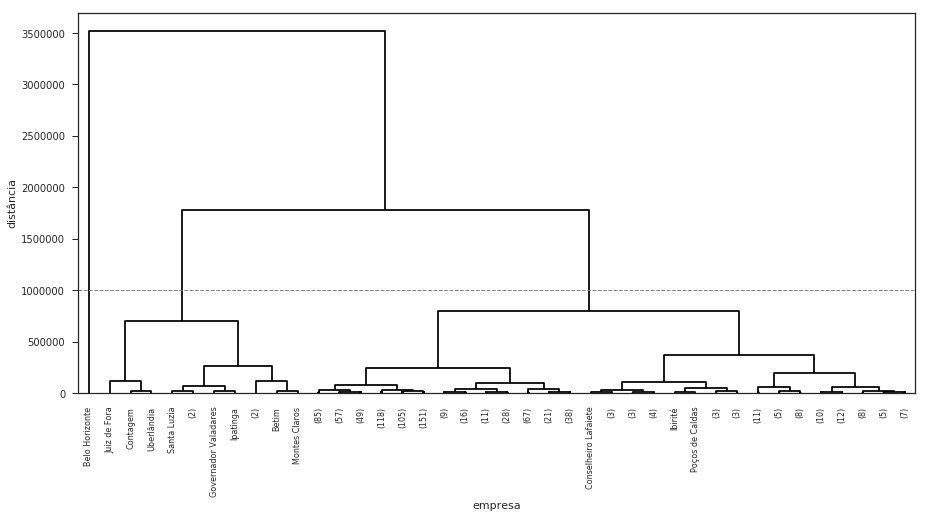

In [31]:
# mostra o ponto de corte na distância max_d
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=40,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('empresa')
plt.ylabel('distância');

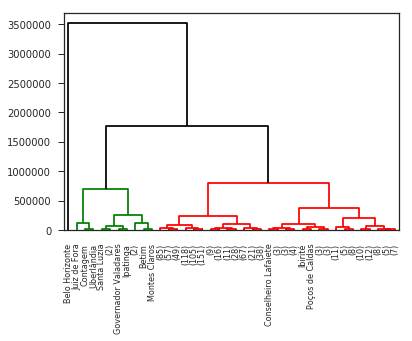

In [32]:
a = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=40,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=max_d, # para que os grupos fiquem com cores diferentes
);

In [33]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos
resultado['grupo'] = grupos

In [34]:
resultado.shape

(853, 3)

In [35]:
resultado

,cp1,cp2,grupo
mun,,,
Abadia dos Dourados,1.192351,-1.225000,0
Abaeté,0.348458,-0.245515,0
Abre Campo,-0.608181,0.072083,0
Acaiaca,-0.502471,-1.057617,0
Açucena,-0.586251,0.343030,0
Água Boa,-0.807500,-1.759757,0
Água Comprida,0.382599,0.938497,0
Aguanil,-0.204900,0.403619,0
Águas Formosas,-0.586063,0.578343,0


In [36]:
# contagem de observações em cada grupo
resultado.grupo.value_counts()

0    840
2     12
1      1
Name: grupo, dtype: int64

In [37]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
dados['grupo'] = grupos
dados.head()

,ibge7,popul,rdpc_formal,tx_mort,prop_priv_saude,grupo
mun,,,,,,
Abadia dos Dourados,3100104,7037,540.70,4.55,15.32,0
Abaeté,3100203,23574,258.94,6.32,14.01,0
Abre Campo,3100302,13726,152.43,7.07,4.26,0
Acaiaca,3100401,4061,132.16,5.17,6.06,0
Açucena,3100500,10066,59.31,7.45,9.40,0


In [38]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados.groupby('grupo').mean()

,ibge7,popul,rdpc_formal,tx_mort,prop_priv_saude
grupo,,,,,
0,3.136944e+06,1.655413e+04,219.283571,6.831095,9.694667
1,3.106200e+06,2.513451e+06,1612.500000,6.180000,48.640000
2,3.142213e+06,3.815533e+05,489.758333,5.903333,33.454167


In [39]:
# mediana das variáveis para cada grupo
dados.groupby('grupo').median()

,ibge7,popul,rdpc_formal,tx_mort,prop_priv_saude
grupo,,,,,
0,3137353.5,8089.5,165.740,6.760,6.105
1,3106200.0,2513451.0,1612.500,6.180,48.640
2,3140002.0,325562.5,477.425,5.655,34.970


In [40]:
# desvio padrão
dados.groupby('grupo').std()

,ibge7,popul,rdpc_formal,tx_mort,prop_priv_saude
grupo,,,,,
0,20696.465082,23449.976232,222.460655,1.638320,9.856076
1,NaN,NaN,NaN,NaN,NaN
2,21655.614365,163220.100403,182.438154,0.981857,9.856633


## As observações de cada grupo

In [41]:
grupo0 = dados.query('grupo == 0').index
pd.DataFrame(list(grupo0))

,0
0,Abadia dos Dourados
1,Abaeté
2,Abre Campo
3,Acaiaca
4,Açucena
5,Água Boa
6,Água Comprida
7,Aguanil
8,Águas Formosas
9,Águas Vermelhas


In [42]:
grupo1 = dados.query('grupo == 1').index
pd.DataFrame(list(grupo1))

,0
0,Belo Horizonte


In [43]:
grupo2 = dados.query('grupo == 2').index
pd.DataFrame(list(grupo2))

,0
0,Betim
1,Contagem
2,Divinópolis
3,Governador Valadares
4,Ipatinga
5,Juiz de Fora
6,Montes Claros
7,Ribeirão das Neves
8,Santa Luzia
9,Sete Lagoas


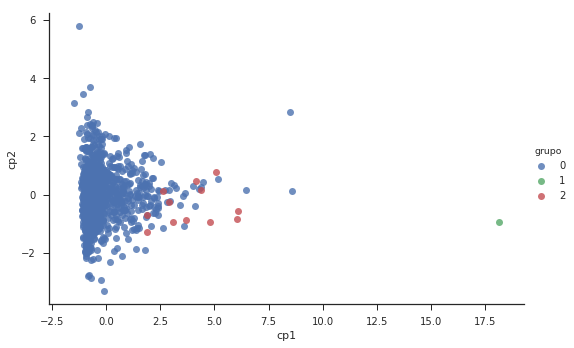

In [44]:
# plotar os escores dos CPs dos 3 grupos
sns.lmplot('cp1', 'cp2', hue='grupo', fit_reg=False, data=resultado, aspect=1.5);

In [45]:
resultado['município'] = resultado.index

In [46]:
# pacote altair para fazer outros tipos de gráficos
# usaremos para o diagrama de dispersão com a cor de acordo com a mesorregião
import altair as alt
alt.renderers.enable('notebook');
# pacote para ter mais opções de paletas de cores
import palettable
# https://vega.github.io/vega/docs/schemes/#reference

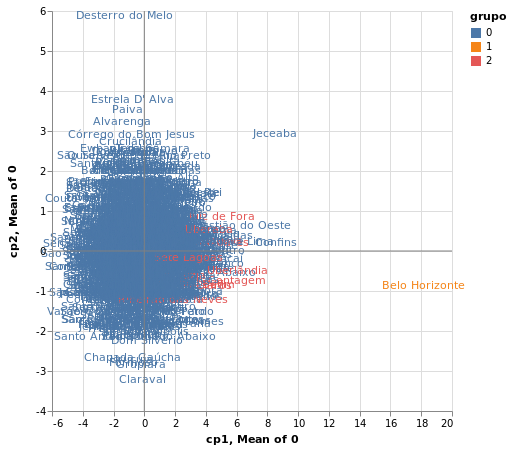

In [49]:
# gráficos
g = alt.Chart(resultado).mark_text().encode(
    alt.X('cp1', scale=alt.Scale(domain=[-5, 20])),
    alt.Y('cp2', scale=alt.Scale(domain=[-4, 6])),
    text='município',
    color=alt.Color('grupo:O', scale=alt.Scale(scheme='tableau10'))
).properties(
    width=400, 
    height=400)#.interactive()

# eixo x = 0
bar_x = alt.Chart(resultado).mark_rule(color='gray').encode(
    x='mean(0):Q')

# eixo y = 0
bar_y = alt.Chart(resultado).mark_rule(color='gray').encode(
    y='mean(0):Q')


g + bar_x + bar_y